In [1]:
import tensorflow_io as tfio

In [2]:
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from performance_evaluation import plot_training_history, evaluate_model_performance

from tensorflow.python.client import device_lib

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    physical_devices[0], enable=True
)

In [4]:
tf.version

<module 'tensorflow._api.v2.version' from '/home/ben/anaconda3/lib/python3.8/site-packages/tensorflow/_api/v2/version/__init__.py'>

# Read in Data

In [5]:
train_data = h5py.File('data/order_history_train.h5', 'r')

In [6]:
train_X_orders = np.array(train_data.get('train_X_orders'))
train_X_order_month = np.array(train_data.get('train_X_order_month'))
train_Y_order = np.array(train_data.get('train_Y_order'))

In [7]:
train_data.close()

In [8]:
test_data = h5py.File('data/order_history_test.h5', 'r')

In [9]:
test_X_orders = np.array(test_data.get('test_X_orders'))
test_X_order_month = np.array(test_data.get('test_X_order_month'))
test_Y_order = np.array(test_data.get('test_Y_order'))

In [10]:
test_data.close()

#### Normalize for Faster Training

In [11]:
def zero_to_ones(value):
    if value ==0:
        return 1
    else:
        return value

range_for_x_cols = np.amax(train_X_orders, axis=0) - np.amin(train_X_orders, axis=0)
range_for_x_cols[range_for_x_cols == 0] = 1

In [12]:
norm_train_x = train_X_orders/range_for_x_cols
norm_test_x = test_X_orders/range_for_x_cols

# Setup Model Architecture

In [13]:
historical_orders = keras.Input(shape=(norm_train_x.shape[1], norm_train_x.shape[2],), name='Order_History')

In [14]:
dropout = .6

In [15]:
i=1

In [16]:
x = layers.GRU(
    100, 
    name=f'GRU1',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout, 
    unroll = False,
    use_bias = True,
    return_sequences=True
)(historical_orders)

In [17]:
x = layers.GRU(
    100, 
    name=f'GRU2',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout,
    unroll = False,
    use_bias = True    
)(x)

In [18]:
x = keras.layers.Flatten()(x)

In [19]:
x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [20]:
x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [21]:
outputs = layers.Dense(6, activation='sigmoid')(x)

In [30]:
model = keras.Model(inputs=historical_orders, outputs=outputs, name="Fully_Connected_Model")

In [31]:
model.summary()

Model: "Fully_Connected_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Order_History (InputLayer)   [(None, 14, 253)]         0         
_________________________________________________________________
GRU1 (GRU)                   (None, 14, 100)           106500    
_________________________________________________________________
GRU2 (GRU)                   (None, 100)               60600     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)     

In [32]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

In [33]:
import datetime

In [34]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [36]:
history = model.fit(
    norm_train_x, train_Y_order, batch_size=20000, epochs=9000, validation_split=0.2,
    callbacks=[tensorboard_callback]
)

Epoch 1/9000
6/6 [==============================] - 2s 343ms/step - loss: 1.9211 - accuracy: 0.4209 - val_loss: 2.0690 - val_accuracy: 0.2669
Epoch 2/9000
6/6 [==============================] - 1s 239ms/step - loss: 1.9202 - accuracy: 0.4206 - val_loss: 1.9656 - val_accuracy: 0.2892
Epoch 3/9000
6/6 [==============================] - 1s 237ms/step - loss: 1.9199 - accuracy: 0.4218 - val_loss: 2.0263 - val_accuracy: 0.2835
Epoch 4/9000
6/6 [==============================] - 1s 239ms/step - loss: 1.9194 - accuracy: 0.4216 - val_loss: 2.0016 - val_accuracy: 0.2858
Epoch 5/9000
6/6 [==============================] - 1s 241ms/step - loss: 1.9179 - accuracy: 0.4222 - val_loss: 1.9438 - val_accuracy: 0.2577
Epoch 6/9000
6/6 [==============================] - 1s 236ms/step - loss: 1.9189 - accuracy: 0.4227 - val_loss: 1.8598 - val_accuracy: 0.3075
Epoch 7/9000
6/6 [==============================] - 1s 247ms/step - loss: 1.9179 - accuracy: 0.4227 - val_loss: 1.9470 - val_accuracy: 0.2833
Epoch 

KeyboardInterrupt: 

In [37]:
plot_training_history(history)

NameError: name 'history' is not defined

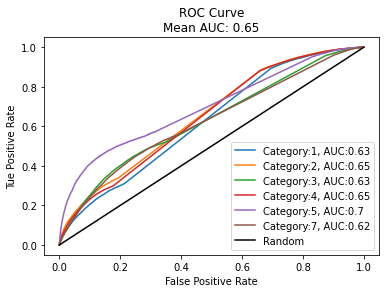

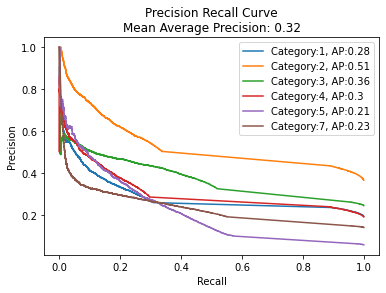

In [38]:
pred_y = model.predict(norm_train_x)
evaluate_model_performance(pred_y, train_Y_order)

#### Test Performance

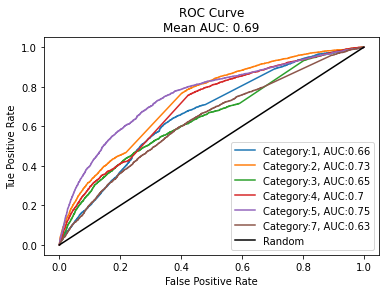

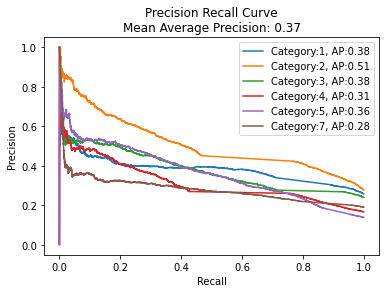

In [39]:
pred_y = model.predict(norm_test_x)
evaluate_model_performance(pred_y, test_Y_order)

# Junk Below

In [ ]:
def fully_connected_network(
    X, layrs, activation, last_activation, dropout, regularizer
):
    input_layer = x = keras.Input(shape=(X.shape[1],), name='Order_History')
    
    i = 0
    for layer in layrs:
        i+=1
        x = layers.BatchNormalization(name=f'BatchNorm{i}')(x)
        x = layers.Dense(layer, activation=activation, name=f'Dense{i}')(x)
        x = layers.Dropout(dropout, name=f'Dropout{i}')(x)
    
    outputs = layers.Dense(6, activation=last_activation)(x)
    
    model = keras.Model(inputs=input_layer, outputs=outputs, name="Fully_Connected_Model")
    return model

In [ ]:
test_Y_order

# Junk Below

#### Read in Data
 - normalize between 0 and 1

In [ ]:
train_x = pd.read_pickle('data/train_x_order_only.pkl').values
train_y = pd.read_pickle('data/train_y_order_only.pkl').values

In [ ]:
test_x = pd.read_pickle('data/test_x_order_only.pkl').values
test_y = pd.read_pickle('data/test_y_order_only.pkl').values

In [ ]:
train_x.shape

In [ ]:
train_y.shape

# Random Numbers

In [ ]:
pred_y = np.random.uniform(0,1,test_y.shape)

In [ ]:
evaluate_model_performance(pred_y, test_y)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## Select Important Features

In [ ]:
# Create Random Variables
random_vars = np.random.uniform(0,1,(135889,3))
train_x_random = np.hstack((train_x, random_vars))

In [ ]:
# Train Model
RF_Model = RandomForestClassifier(n_jobs=-1, max_depth=10)
RF_Model.fit(train_x_random, train_y)

In [ ]:
from performance_evaluation import model_vars

In [ ]:
model_vars_random = np.array(model_vars+['rand1', 'rand2', 'rand3'])

In [ ]:
variable_importance = pd.DataFrame(
    [RF_Model.feature_importances_], columns=model_vars_random
)

#### Grab Variables with importance > Max of the 3 random variables

In [ ]:
average_random_importance = variable_importance[['rand1', 'rand2', 'rand3']].T.max()[0]

In [ ]:
significant_var_mask = np.argwhere(RF_Model.feature_importances_ > average_random_importance)

In [ ]:
sig_var_names = model_vars_random[significant_var_mask][:,0]
sig_var_importance = RF_Model.feature_importances_[significant_var_mask][:,0]
sig_var_df = pd.DataFrame([sig_var_importance], columns = sig_var_names)
sig_var_df = sig_var_df.T.sort_values(0,ascending=False)

In [ ]:
plt.rcParams["figure.figsize"] = (5,10)

In [ ]:
plt.barh(sig_var_df.index, sig_var_df[0])
plt.title('Significant Variables in Model')
plt.show()

## Train Model on Significant Features

In [ ]:
sig_train_x = train_x[:,significant_var_mask[:,0]]

In [ ]:
# Train Model
RF_Model = RandomForestClassifier(n_jobs=-1, max_depth=20)
RF_Model.fit(sig_train_x, train_y)

In [ ]:
sig_test_x = test_x[:,significant_var_mask[:,0]]

In [ ]:
train_pred_y = np.array(RF_Model.predict_proba(sig_train_x))
train_pred_y = train_pred_y[:,:,1].T

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

In [ ]:
evaluate_model_performance(train_pred_y, train_y)

In [ ]:
test_pred_y = np.array(RF_Model.predict_proba(sig_test_x))
test_pred_y = test_pred_y[:,:,1].T

In [ ]:
evaluate_model_performance(test_pred_y, test_y)

# Deep Fully Connected NN

#### Normalize for Faster Training

In [ ]:
def zero_to_ones(value):
    if value ==0:
        return 1
    else:
        return value

In [ ]:
range_for_x_cols = np.amax(train_x, axis=0) - np.amin(train_x, axis=0)
range_for_x_cols = np.array([zero_to_ones(x) for x in range_for_x_cols])

In [ ]:
norm_train_x = train_x/range_for_x_cols
norm_test_x = test_x/range_for_x_cols

# Build Model

In [ ]:
def fully_connected_network(
    X, layrs, activation, last_activation, dropout, regularizer
):
    input_layer = x = keras.Input(shape=(X.shape[1],), name='Order_History')
    
    i = 0
    for layer in layrs:
        i+=1
        x = layers.BatchNormalization(name=f'BatchNorm{i}')(x)
        x = layers.Dense(layer, activation=activation, name=f'Dense{i}')(x)
        x = layers.Dropout(dropout, name=f'Dropout{i}')(x)
    
    outputs = layers.Dense(6, activation=last_activation)(x)
    
    model = keras.Model(inputs=input_layer, outputs=outputs, name="Fully_Connected_Model")
    return model

In [ ]:
fc_layers = [800, 400, 400, 200, 200, 100, 50, 10]

In [ ]:
model = fully_connected_network(norm_train_x, fc_layers, 'elu', 'sigmoid', .8, 1)

In [ ]:
model.summary()

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(norm_train_x, train_y, batch_size=1000, epochs=20000, validation_split=0.2)

In [ ]:
plot_training_history(history)

#### Training Performance

In [ ]:
pred_y = model.predict(norm_train_x)
evaluate_model_performance(pred_y, train_y)

#### Test Performance

In [ ]:
pred_y = model.predict(norm_test_x)
evaluate_model_performance(pred_y, test_y)